<a href="https://colab.research.google.com/github/orlandxrf/curso-dl/blob/main/notebooks/7a_TextCNN_Emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red Neuronal Convolucional
Dado el conjunto de datos se desarrollará una CNN con una red densa para clasificar sentimientos

In [33]:
# establecer parametros para almacenar y cargar el conjunto de datos del repositorio de Github
import os

URL = 'https://raw.githubusercontent.com/orlandxrf/curso-dl/main/data/text_emotion.csv'
data_folder = 'data'
filepath = os.path.join(data_folder, 'text_emotion.csv')

### Cargar el conjunto de datos

In [34]:
# crear carpeta para almacenar el conjunto de datos
! mkdir {data_folder}
# descargar conjunto de datos y alamcenar
! wget -nc {URL} -O {filepath}

mkdir: cannot create directory ‘data’: File exists
File ‘data/text_emotion.csv’ already there; not retrieving.


In [35]:
# comprobrar
! ls -lh data/*

-rw-r--r-- 1 root root 4.2M Feb 26 01:47 data/text_emotion.csv


# Analizar conjunto de datos

In [36]:
import pandas as pd

df = pd.read_csv('data/text_emotion.csv')

# eliminar columnas 'tweet_id' y 'author'
df.drop('tweet_id',axis=1,inplace=True)
df.drop('author',axis=1,inplace=True)
print (df.head(10))
print (f"Longitud de tweets: {len(df):,}")

    sentiment                                            content
0       empty  @tiffanylue i know  i was listenin to bad habi...
1     sadness  Layin n bed with a headache  ughhhh...waitin o...
2     sadness                Funeral ceremony...gloomy friday...
3  enthusiasm               wants to hang out with friends SOON!
4     neutral  @dannycastillo We want to trade with someone w...
5       worry  Re-pinging @ghostridah14: why didn't you go to...
6     sadness  I should be sleep, but im not! thinking about ...
7       worry               Hmmm. http://www.djhero.com/ is down
8     sadness            @charviray Charlene my love. I miss you
9     sadness         @kelcouch I'm sorry  at least it's Friday?
Longitud de tweets: 40,000


1	8638	neutral
2	8459	worry
3	5209	happiness
4	5165	sadness
5	3842	love
6	2187	surprise
7	1776	fun
8	1526	relief
9	1323	hate
10	827	empty
11	759	enthusiasm
12	179	boredom
13	110	anger

40,000 tweets


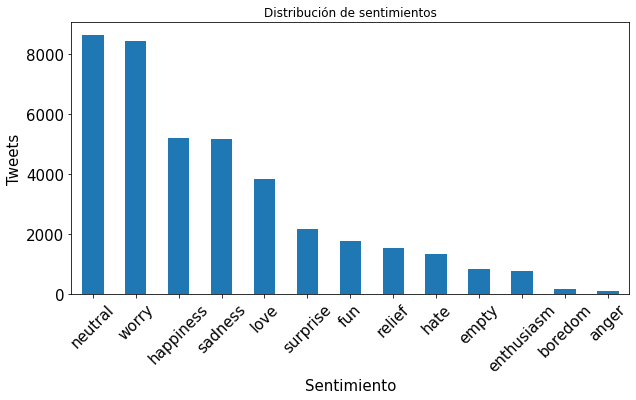

In [37]:
import matplotlib.pyplot as plt

sentiments = dict(pd.value_counts(df['sentiment']))
classes = list(sentiments.keys())
for i, sent in enumerate(sentiments):
  print (f"{i+1}\t{sentiments[sent]}\t{sent}")
print (f"\n{len(df):,} tweets")

# Graficar la distribución
plt.figure(figsize=(10, 5))
pd.value_counts(df['sentiment']).plot.bar(title="Distribución de sentimientos")
plt.xlabel("Sentimiento", fontsize="15")
plt.ylabel("Tweets", fontsize="15")
plt.xticks(rotation=45, fontsize="15")
plt.yticks(fontsize="15")
plt.show()

# Preprocesamiento de los datos

In [38]:
# preprocesamiento

def limpiar_tweets(text):
    import re  
    # elimina usuarios y URLS
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    # elimina múltiples espacios en blanco
    text = re.sub(r' +', ' ', text)
    # elimina el salto de línea
    text = re.sub(r'\n', ' ', text)
    return text.lower()

clean_df = df.copy()
clean_df['content'] = df.apply(lambda row : limpiar_tweets(row['content']), axis=1)

print (df.head(10))
print('\nNormalized:')
print(clean_df.head(10))

print (f"Tweets limpios: {len(clean_df):,}")

# removes nan y tweets duplicados
clean_df = clean_df.dropna().drop_duplicates()
print (f"Despues de remover tweets nan y duplicados: {len(clean_df):,}")

for index, row in clean_df.iterrows():
  if row['content'].strip() == "":
    print (f"index: {index}\tclase: {row['sentiment']}\ttweet: {row['content']}")
    clean_df.drop([index], inplace = True )
  elif len(row['content'].split()) < 5: # eliminar tweets menores a 5 palabras
    clean_df.drop([index], inplace = True )
print (f"Despues de remover tweets vacíos: {len(clean_df):,}")

print ("\nTWEETS DESPUES DE LA LIMPIEZA")
sentiments = dict(pd.value_counts(clean_df['sentiment']))
classes = list(sentiments.keys())
for i, sent in enumerate(sentiments):
  print (f"{i+1}\t{sentiments[sent]}\t{sent}")
print (f"\n{len(clean_df):,} tweets")



    sentiment                                            content
0       empty  @tiffanylue i know  i was listenin to bad habi...
1     sadness  Layin n bed with a headache  ughhhh...waitin o...
2     sadness                Funeral ceremony...gloomy friday...
3  enthusiasm               wants to hang out with friends SOON!
4     neutral  @dannycastillo We want to trade with someone w...
5       worry  Re-pinging @ghostridah14: why didn't you go to...
6     sadness  I should be sleep, but im not! thinking about ...
7       worry               Hmmm. http://www.djhero.com/ is down
8     sadness            @charviray Charlene my love. I miss you
9     sadness         @kelcouch I'm sorry  at least it's Friday?

Normalized:
    sentiment                                            content
0       empty  i know i was listenin to bad habit earlier and...
1     sadness  layin n bed with a headache ughhhh waitin on y...
2     sadness                     funeral ceremony gloomy friday
3  enthusias

# Preparar el conjunto de datos

In [39]:
# obtener diccionario de clases (Y)
# sentiments = df_filtered['sentiment'].to_dict()
sentiments = clean_df['sentiment'].to_dict()

labels = list(set(sentiments.values()))
labels.sort()
print (labels)

label2idx = {label:i for i, label in enumerate(labels)}
idx2label = {label2idx[lbl] : lbl for lbl in label2idx}

print (f"label2idx= {label2idx}")
print (f"idx2label= {idx2label}")

print (f"Número de etiquetas (clases): {len(label2idx):,}")

['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness', 'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise', 'worry']
label2idx= {'anger': 0, 'boredom': 1, 'empty': 2, 'enthusiasm': 3, 'fun': 4, 'happiness': 5, 'hate': 6, 'love': 7, 'neutral': 8, 'relief': 9, 'sadness': 10, 'surprise': 11, 'worry': 12}
idx2label= {0: 'anger', 1: 'boredom', 2: 'empty', 3: 'enthusiasm', 4: 'fun', 5: 'happiness', 6: 'hate', 7: 'love', 8: 'neutral', 9: 'relief', 10: 'sadness', 11: 'surprise', 12: 'worry'}
Número de etiquetas (clases): 13


In [53]:
# obtener diccionario de tweets (X)
# tweets = df_filtered['content'].to_list()
tweets = clean_df['content'].to_list()

tokens = set({token.lower() for tweet in tweets for token in tweet.split()})
tokens2idx = {'pad': 0, 'unk': 1} # definir 'PAD': para rellenar tweets y 'UNK' para palabras fuera del vocabulario
for i, token in enumerate(tokens):
  if token not in tokens2idx:
    tokens2idx.update({token : i+2 })
# print (tokens2idx)
print (f"Longitud del vocabulario: {len(tokens2idx):,}")

max_tweet_length = 0
min_tweet_length = 100

X, Y = [], []
count_length_lower_tweets = []

# for index, row in df_filtered.iterrows():
for index, row in clean_df.iterrows():

  # reemplazar la etiqueta (sentiment) por su id en el conjunto de datos
  label = row['sentiment']
  # df_filtered.at[index, 'sentiment'] = label2idx[label]
  Y.append(label2idx[label])

  # obtener la longitud máxima y mínima del tweet
  if len(row['content'].split()) > max_tweet_length: max_tweet_length = len(row['content'].split())
  if len(row['content'].split()) < min_tweet_length:
    min_tweet_length = len(row['content'].split())
    print (f"{index}\t{row['sentiment']}\t{row['content']}")

print (f"Tweet con la longitud máxima: {max_tweet_length:,}")
print (f"Tweet con la longitud mínima: {min_tweet_length:,}")
# print (f"Tweet de longitud cero: {len(count_length_lower_tweets):,}")


# for index, row in df_filtered.iterrows():
for index, row in clean_df.iterrows():

  # reemplazar token en el tweet
  idx2token = [tokens2idx[token] for token in row['content'].lower().split()]

  # verificar si el tweet actual cuenta con la longitud máxima
  if len(idx2token) < max_tweet_length:
    n_padding = max_tweet_length - len(idx2token)
    idx2token += [tokens2idx['pad']] * n_padding # rellenar tweet

  X.append(idx2token)

print (f"Longitud X: {len(X)}")
print (f"Longitud Y: {len(Y)}")


Longitud del vocabulario: 29,942
0	empty	i know i was listenin to bad habit earlier and i started freakin at his part
1	sadness	layin n bed with a headache ughhhh waitin on your call
3	enthusiasm	wants to hang out with friends soon
8	sadness	charlene my love i miss you
37	worry	i need skott right now
Tweet con la longitud máxima: 40
Tweet con la longitud mínima: 5
Longitud X: 35433
Longitud Y: 35433


# Embeddings
Obtener representaciones vectoriales de alguno de los siguientes repositorios:<br>
*   [GloVe](https://nlp.stanford.edu/projects/glove/)
*   [FasText](https://fasttext.cc/)
*   [Word2vec](https://code.google.com/archive/p/word2vec/)

En este caso se usará GloVE `glove.6B.50d` con la ayuda de la biblioteca de Python `torchtext`

## Crear matriz de embeddings
Definir una matriz con ceros del tamaño de nuestro vocalurio y con la logitud de los embeddings seleccionados.


In [41]:
import numpy as np
import torch

emb_dim = 100 # es la longitud de los embbeddins seleccionados


# Dividir el conjunto de datos en Train y Test

In [42]:
import numpy as np

# preparar el conjunto de datos
Y = np.array(Y, dtype="float32")[:, np.newaxis]
print (f"Shape Y:\t{Y.shape}")
# print (Y)

X = np.array(X, dtype="float32")
print (f"\nShape X:\t{X.shape}")
# print (X)


Shape Y:	(35433, 1)

Shape X:	(35433, 40)


In [43]:
# dividir el conjunto de entrenamiento en Train and Test
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, stratify=Y, random_state=41)
X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, test_size=0.30, stratify=Y_test, random_state=41)

print(f"X_train.shape, Y_train.shape: {X_train.shape}, {Y_train.shape}")
print(f"X_val.shape, Y_val.shape: {X_valid.shape}, {Y_valid.shape}")
print(f"X_test.shape, Y_test.shape: {X_test.shape}, {Y_test.shape}")



X_train.shape, Y_train.shape: (24803, 40), (24803, 1)
X_val.shape, Y_val.shape: (3189, 40), (3189, 1)
X_test.shape, Y_test.shape: (7441, 40), (7441, 1)


### TensorDataset y DataLoader

In [44]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# crear los tensores del conjunto de datos
train = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
valid = TensorDataset(torch.tensor(X_valid), torch.tensor(Y_valid))
test = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

# print (train[0])
# print (valid[0])
# print (test[0])

batch_size = 64

# crear los cargadores del conjunto de datos
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test, batch_size=batch_size, shuffle=True)



# Definir bibliotecas pytorch
Definimos la importación de la bibliotecas necesarias

In [45]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


## Crear capa de Embeddings
Definir una capa para los embeddings mediante una función

# Definir el modelo de la TextCNN


In [46]:
class CNN_Text(nn.Module):
    ''' Define network architecture and forward path. '''
    def __init__(self, vocab_size, vector_size, n_filters, filter_sizes, output_dim, dropout, pad_idx):
        
        super().__init__()
        
        # definir la capa de embeddings
        self.embedding = nn.Embedding(vocab_size+1, vector_size)
        
        # definir capas de convolución
        # torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = 1, 
                                  out_channels = n_filters, 
                                  kernel_size = (fs, vector_size)) 
                                    for fs in filter_sizes])
        
        self.linear1 = nn.Linear(len(filter_sizes) * n_filters, 100)

        self.activation = nn.ReLU()

        self.linear2 = nn.Linear(100, 100)

        self.linear3 = nn.Linear(100, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):

      embedded = self.embedding(text).unsqueeze(1)
      
      conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

      pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

      cat = self.dropout(torch.cat(pooled, dim=1))

      out = self.linear1(cat)
      out = self.activation(out)

      out = self.linear2(out)
      out = self.activation(out)

      return self.linear3(out)

In [47]:
vocab_size = len(tokens2idx)
# emb_dim = definida arriba, para los embeddings
n_filters = 100
filter_sizes = [1,2,3]
output_dim = len(label2idx)
dropout = 0.3

# --------------------------------------------------------------
PAD_IDX = 0 # definir el token para rellenar "<pad>"

model = CNN_Text(vocab_size, emb_dim, n_filters, filter_sizes, output_dim, dropout, PAD_IDX)

model.embedding.weight.data[PAD_IDX] = torch.zeros(emb_dim)
# --------------------------------------------------------------

print (model)

CNN_Text(
  (embedding): Embedding(29943, 100)
  (convs): ModuleList(
    (0): Conv1d(1, 100, kernel_size=(1, 100), stride=(1,))
    (1): Conv1d(1, 100, kernel_size=(2, 100), stride=(1,))
    (2): Conv1d(1, 100, kernel_size=(3, 100), stride=(1,))
  )
  (linear1): Linear(in_features=300, out_features=100, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=13, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


# Entrenamiento de la TextCNN

## Funciones para el entrenamiento

In [48]:
# definir funciones para utilizar en el entrenamiento y evaluación
def accuracy(preds, y):
    """Retorna el accuracy por batch"""
    correct = (torch.round(torch.sigmoid(preds)) == y).float() # usar sigmoid para la evaluación
    # correct = (torch.round(F.softmax(preds)) == y).float() # usar softmax para la evaluación
    # correct = [1 for i, j in zip(torch.argmax(y, dim=1), y) if i == j] # elegir el argumento máximo
    return correct.sum() / len(correct)

def epoch_time(start_time, end_time):
    """Obtener el tiempo en minutos y segundos"""
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [49]:
# función del entrenamieto
def train(model, iterator, optimizer, loss_function):
    """
    Entrenar el modelo, recibe el conjunto de datos (iterator), optimizador, y la función de pérdida
    Retorna el loss y el accuracy
    """
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for x_text, y_label in iterator:

        x_text = torch.tensor(x_text.clone().detach(), dtype=torch.long)
        y_label = torch.tensor(y_label.clone().detach(), dtype=torch.long)
        
        # restablecer el gradiente
        optimizer.zero_grad()
        
        # obtener las predicciones del batch en proceso
        predictions = model(x_text).squeeze(1)
        
        target = torch.tensor(y_label.squeeze(1), dtype=torch.long).clone().detach()
        # obtener la pérdida 
        loss = loss_function(predictions, target)
        
        # calcular el accuracy
        acc = accuracy(predictions, y_label)
        
        # Backpropagation
        loss.backward()
        
        # Actualizar (optimizar) los pesos
        optimizer.step()
        
        # Almacenar loss y accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, loss_function):
    """
    Evaluar el conjunto de validación y/o el conjunto de prueba
    Retorna el loss y accuracy
    """
    epoch_loss = 0
    epoch_acc = 0
    
    # indicar la evaluación del modelo
    model.eval()
    
    # No utilizar cálculos del gradiente
    with torch.no_grad():
    
        for x_text, y_label in iterator:

            x_text = torch.tensor(x_text, dtype=torch.long).clone().detach()
            y_label = torch.tensor(y_label, dtype=torch.long).clone().detach()

            predictions = model(x_text).squeeze(1)
            target = torch.tensor(y_label.squeeze(1), dtype=torch.long).clone().detach()
            
            loss = loss_function(predictions, target)
            
            acc = accuracy(predictions, y_label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Realizar entrenamiento

In [50]:
import time
# entrenamiento
N_EPOCHS = 5
# float('inf') actúa como un valor superior ilimitado para la comparación.
# esto es útil para encontrar los valores más bajos
best_valid_loss = float('inf')
val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

# definir optimizador
optimizer = optim.Adam(model.parameters()) # lr=6e-3

# definir la función de perdida
loss_function = nn.CrossEntropyLoss()

for epoch in range(N_EPOCHS):
    
    # calcular el tiempo que tarda cada epoca
    start_time = time.time() # inicializar
    
    # obtener el loss del conjunto de entrenamiento
    train_loss, train_acc = train(model, trainloader, optimizer, loss_function)

    # obtener el loss del conjunto de validación
    valid_loss, valid_acc = evaluate(model, validloader, loss_function)
    
    end_time = time.time() # obtener el tiempo final
    # obtener los minutos y segundos del tiempo de ejecución
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Almacenar las metricas del entrenamiento
    val_loss.append(valid_loss)
    val_acc.append(valid_acc)
    tr_loss.append(train_loss)
    tr_acc.append(train_acc)
    
    if valid_loss < best_valid_loss: # guardar el mejor modelo
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'CNN-model.pt')
    
    print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

Epoch:  1 | Epoch Time: 0m 37s
	Train Loss: 2.125 | Train Acc: 4.59%
	 Val. Loss: 2.046 |  Val. Acc: 4.16%
Epoch:  2 | Epoch Time: 0m 36s
	Train Loss: 1.999 | Train Acc: 4.58%
	 Val. Loss: 1.976 |  Val. Acc: 4.28%
Epoch:  3 | Epoch Time: 0m 36s
	Train Loss: 1.917 | Train Acc: 4.49%
	 Val. Loss: 1.962 |  Val. Acc: 4.31%
Epoch:  4 | Epoch Time: 0m 36s
	Train Loss: 1.844 | Train Acc: 4.47%
	 Val. Loss: 1.994 |  Val. Acc: 4.34%
Epoch:  5 | Epoch Time: 0m 36s
	Train Loss: 1.767 | Train Acc: 4.48%
	 Val. Loss: 1.989 |  Val. Acc: 4.28%


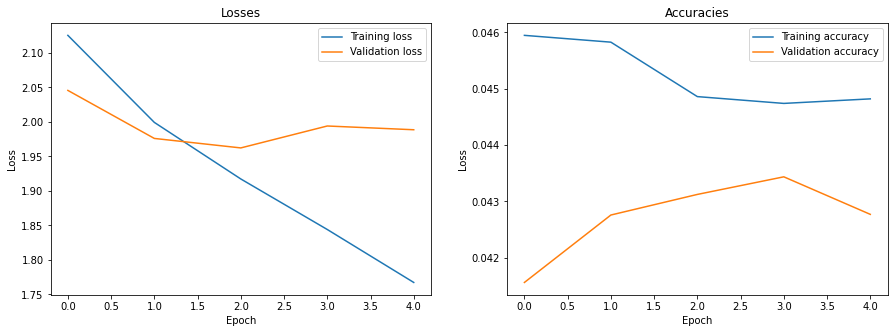

In [51]:
# Graficar accuracy y loss
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(tr_loss, label='Training loss')
ax[0].plot(val_loss, label='Validation loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(tr_acc, label='Training accuracy')
ax[1].plot(val_acc, label='Validation accuracy')
ax[1].set_title('Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.legend()
plt.show()

## Evaluar el modelo

In [52]:
# Evaluarv el modelo con el conjunto de prueba (test)
model.load_state_dict(torch.load('CNN-model.pt'))

test_loss, test_acc = evaluate(model, testloader, loss_function)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test Loss: 1.952 | Test Acc: 4.58%
